In [8]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from gensim.parsing.preprocessing import STOPWORDS

import matplotlib.pyplot as plt


In [9]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('clinical_trials_on_cancer_data_clasificacion.csv', sep=',', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data_t=data


In [10]:
def moda(dict):
    diccionario_conteo = {}
    for clave in dict:
        # Si no existe...
        if not clave in diccionario_conteo:
            # lo agregamos:
            diccionario_conteo[clave] = 1
        # Si ya existe...
        else:
            # Lo aumentamos
            diccionario_conteo[clave] += 1

In [11]:
textos = data_t.copy()
textos['Conteo'] = [len(x) for x in textos['study_and_condition']]
#textos['Moda'] = [max(moda(textos['study_and_condition']))]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['study_and_condition']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['study_and_condition']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(textos)

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Métodos para hacer limpieza y preparación de los datos

In [12]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
    
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word in STOPWORDS:
            continue
        else:
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

#data_t = data_t.applymap (lambda row: preprocessing(row))

Visualización de los datos

In [13]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   label                12000 non-null  object
 1   study_and_condition  12000 non-null  object
dtypes: object(2)
memory usage: 187.6+ KB


Separar la variable objetivo

In [14]:
Y = data_t["label"]
X = data_t.drop(["label"], axis=1)

In [15]:
X.head()

,study_and_condition
0,study interventions are Saracatinib . recurren...
1,study interventions are Stem cell transplantat...
2,study interventions are Lenograstim . recurren...
3,study interventions are Doxorubicin . stage ii...
4,study interventions are Poly I-C . prostate ca...


In [16]:
Y.head()

0    __label__0
1    __label__1
2    __label__0
3    __label__0
4    __label__1
Name: label, dtype: object

Volver la variable objetivo a numérica

In [17]:
Y = Y.replace({'__label__0': 0, '__label__1': 1})

In [18]:
Y.head()

0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64

Aplica la corrección de las contracciones

In [19]:
for_tokenize = data_t.copy()

for_tokenize['study_and_condition'] = for_tokenize['study_and_condition'].apply(contractions.fix) #Aplica la corrección de las contracciones

In [20]:
for_tokenize.head()

,label,study_and_condition
0,__label__0,study interventions are Saracatinib . recurren...
1,__label__1,study interventions are Stem cell transplantat...
2,__label__0,study interventions are Lenograstim . recurren...
3,__label__0,study interventions are Doxorubicin . stage ii...
4,__label__1,study interventions are Poly I-C . prostate ca...


Limpiar los datos y tokenizar

In [21]:
for_tokenize['study_and_condition'] = for_tokenize['study_and_condition'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
for_tokenize.head()

,label,study_and_condition
0,__label__0,"[study, interventions, saracatinib, recurrent,..."
1,__label__1,"[study, interventions, stem, cell, transplanta..."
2,__label__0,"[study, interventions, lenograstim, recurrent,..."
3,__label__0,"[study, interventions, doxorubicin, stage, iii..."
4,__label__1,"[study, interventions, poly, ic, prostate, can..."


Volver la lista de tokens a una string

In [30]:
def turn_tokens_sentence(row):
    new_string = ""
    #print(row['study_and_condition'])
    for word in row['study_and_condition']:
        new_string += word + " "
    return new_string

for_tokenize_1 = for_tokenize.copy()    
for_tokenize_1['study_and_condition'] = for_tokenize_1.apply(lambda row: turn_tokens_sentence(row), axis=1)         

In [31]:
for_tokenize_1.head()

,label,study_and_condition
0,__label__0,study interventions saracatinib recurrent verr...
1,__label__1,study interventions stem cell transplantation ...
2,__label__0,study interventions lenograstim recurrent adul...
3,__label__0,study interventions doxorubicin stage iii diff...
4,__label__1,study interventions poly ic prostate cancer di...


Creación de los modelos

Usar CountVectorizer para volver las frases a una matriz de vectores que pueda ser usada con las librerías de sklearn

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

x_ar = vectorizer.fit_transform(for_tokenize_1.study_and_condition)


Se ejecuta TfidfTransformer para remover las palabras que se usan mucho en todos los documentos pero no aportan

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False)

# learn the vocabulary and store tf-idf sparse matrix in tfidf
tfidf = transformer.fit_transform(x_ar.toarray())

# retrieving matrix in numpy form as we did it before
tf = tfidf.toarray()

In [34]:
num_rows, num_cols = tf.shape
print(num_rows, num_cols)

12000 8209


In [35]:
# Dividir los datos en entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(tf, Y, test_size=0.2, random_state=0)

Primero se ejecutará el modelo de Bag Of Words con la implementación de MultinomialNB

In [36]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, Y_train)

In [37]:
y_pred = clf.predict(X_test)

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1228
           1       0.76      0.80      0.78      1172

    accuracy                           0.78      2400
   macro avg       0.78      0.78      0.78      2400
weighted avg       0.78      0.78      0.78      2400



Luego se implementará el modelo de árboles de decisión

In [39]:
# Para crear el arbol de decisión 
from sklearn.tree import DecisionTreeClassifier 

# Crear el objeto de arbol de decisión. Utilicemos como criterio de pureza la entropía.
arbol = DecisionTreeClassifier(criterion='entropy', random_state=0)

# Entrenar el modelo de arbol de decisión con los datos de entrenamiento
arbol = arbol.fit(X_train, Y_train)

In [40]:
# Determinamos las predicciones del modelo sobre el conjunto test.
y_pred = arbol.predict(X_test)

In [41]:
# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72      1228
           1       0.71      0.74      0.72      1172

    accuracy                           0.72      2400
   macro avg       0.72      0.72      0.72      2400
weighted avg       0.72      0.72      0.72      2400



In [42]:
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 

# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,20],'min_samples_split':[2, 3, 4, 5]}

In [43]:
# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = DecisionTreeClassifier(random_state=0)

In [44]:
# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol, param_grid, n_jobs = -1,cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 20],
                         'min_samples_split': [2, 3, 4, 5]})

In [45]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 4}

In [46]:
# Obtener el mejor modelo.
arbol_final = mejor_modelo.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = arbol_final.predict(X_train)
y_pred_test = arbol_final.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.76
Exactitud sobre test: 0.68


In [47]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.58      0.65      1228
           1       0.64      0.78      0.71      1172

    accuracy                           0.68      2400
   macro avg       0.69      0.68      0.68      2400
weighted avg       0.69      0.68      0.68      2400



In [48]:
# Obtener la importancia de las variables. Para esto podemos utilizar uno de los atributos del modelo "feature_importances_", el
# cual nos devuelve un coeficiente o peso para cada atributo: mientras más grande sea este más importante será la variable
# asociada.
importancia= arbol_final.feature_importances_

importancia_atributo = pd.DataFrame(data={"Atributo": vectorizer.get_feature_names(),"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,history,0.083370
1,diagnosis,0.064847
2,active,0.045387
3,doc,0.041459
4,zero,0.040912
...,...,...
8204,fascicular,0.000000
8205,fascial_dehiscence,0.000000
8206,farnesyl_transferase,0.000000
8207,fanconi,0.000000


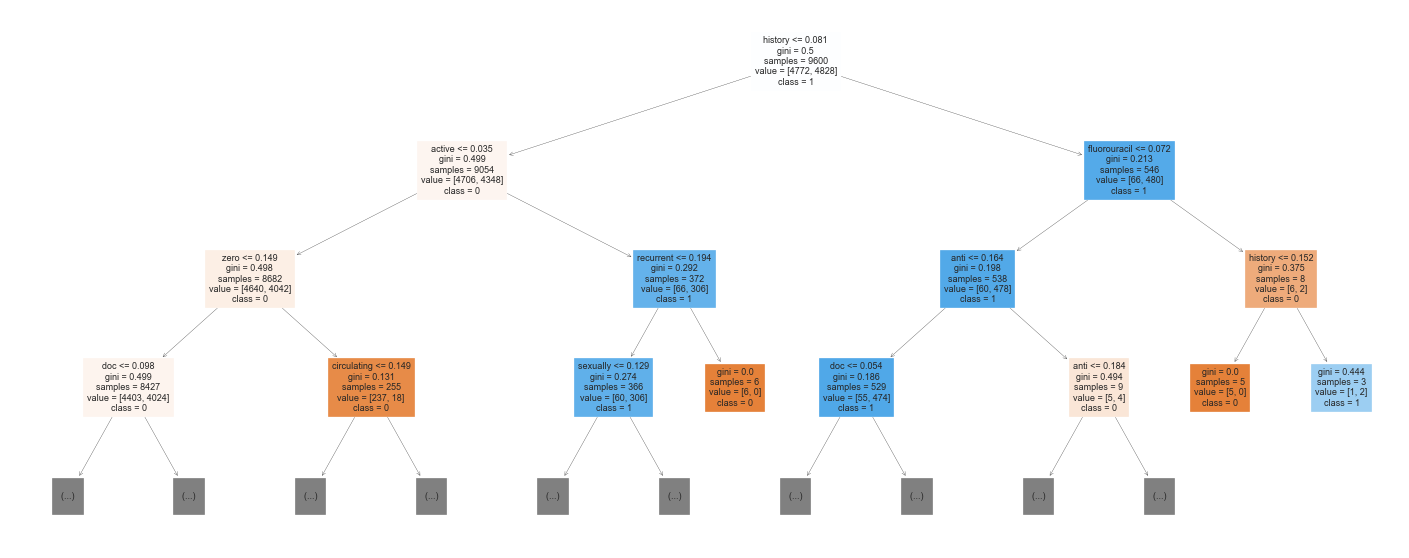

In [49]:
import seaborn as sns 
from sklearn import tree as tree

fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(arbol_final, max_depth=3, feature_names=vectorizer.get_feature_names(), class_names=["0", "1"], filled=True, fontsize=9)

In [ ]:
Por último, se implementará el modelo de Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

# Crear modelo
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

In [51]:
#Predecir
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.99
Exactitud sobre test: 0.76


In [52]:
# Mostrar reporte de clasificación sobre test
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1228
           1       0.76      0.75      0.76      1172

    accuracy                           0.76      2400
   macro avg       0.76      0.76      0.76      2400
weighted avg       0.76      0.76      0.76      2400



In [53]:
# Primero definamos el espacio de búsqueda
n_estimadores =  list(range(1,10))
max_features = list(range(1,5))

In [54]:
param_grid = {'n_estimators': n_estimadores, 'max_features': max_features}

In [55]:
clasificadorRF = RandomForestClassifier()
modelo_RF = GridSearchCV(clasificadorRF , param_grid, n_jobs = -1, cv=particiones)
modelo_RF.fit(X_train,Y_train) 
print("Mejor parámetro: {}".format(modelo_RF.best_params_)) 
print("Mejor cross-validation score: {:.2f}".format(modelo_RF.best_score_))

Mejor parámetro: {'max_features': 4, 'n_estimators': 9}
Mejor cross-validation score: 0.75


In [56]:
# Obtener el mejor modelo.
modelo_final = modelo_RF.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = modelo_final.predict(X_train)
y_pred_test = modelo_final.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.99
Exactitud sobre test: 0.74


In [57]:
# Mostrar reporte de clasificación sobre test
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1228
           1       0.73      0.75      0.74      1172

    accuracy                           0.74      2400
   macro avg       0.74      0.74      0.74      2400
weighted avg       0.74      0.74      0.74      2400



In [58]:
importancia= modelo_RF.best_estimator_.feature_importances_

importancia_atributo = pd.DataFrame(data={"Atributo": vectorizer.get_feature_names(),"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,diagnosis,0.018471
1,interventions,0.018148
2,study,0.015059
3,cancer,0.008510
4,lymphoma,0.006658
...,...,...
8204,nct,0.000000
8205,ne,0.000000
8206,necessarily,0.000000
8207,necrolysis,0.000000


In [22]:
# training word2vec model
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
mymodel = Word2Vec(for_tokenize.study_and_condition, min_count=1)

In [23]:
#try finding most similar words for word "Data"
mymodel.wv.most_similar("cancer")

[('adenocarcinoma', 0.8693134188652039),
 ('neoplasms', 0.8386775255203247),
 ('paclitaxel', 0.8025188446044922),
 ('letrozole', 0.800939679145813),
 ('trastuzumab', 0.7976952195167542),
 ('hrpos', 0.7942589521408081),
 ('estramustine', 0.7935447692871094),
 ('anastrozole', 0.7927049398422241),
 ('melanoma', 0.7827208638191223),
 ('docetaxel', 0.7778804898262024)]